<a href="https://colab.research.google.com/github/markingle/deeplearning/blob/master/AddressToFacilityInfo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense

import numpy as np

import seaborn as sns

# added to support graphs
import matplotlib.pyplot as plt

In [2]:
#mount my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Only run this if you need to upload the csv file a second time.
!rm -rf '/content/AddressesByFacilitiesAndSpeedsReport_Cleaned.csv'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving AddressesByFacilitiesAndSpeedsReport_Cleaned.csv to AddressesByFacilitiesAndSpeedsReport_Cleaned.csv


In [ ]:
import pandas as pd
data = pd.read_csv('/content/AddressesByFacilitiesAndSpeedsReport_Cleaned.csv')

df = data.copy()

In [ ]:
# This shows the number of classes in the y output....the size of this data dictates the size and dimension of the tensor - x, y, z
# When the models prediction is incorrect it is with the Node because there are so many in the dataset....to make improvements more data is needed.  Increasing the number of epochs has dimenishing return.

print("Unique Speed classes:", df["Speeds"].nunique())
print("Unique Node classes:", df["Node"].nunique())

Unique Speed classes: 4
Unique Node classes: 301


In [ ]:
# Combines address fields into a single string
df["Full_Address"] = (
    df["Street_Number"].astype(str).fillna("") + " " +
    df["Street_Name"].fillna("") + " " +
    df["City"].fillna("") + " " +
    df["State"].fillna("") + " " +
    df["Zip_Code"].astype(str).fillna("")
).str.strip()

In [ ]:
df.head()

,Street_Number,Street_Name,Apartment_Number,City,State,Zip_Code,Number_of_Facility_Types,Facility_Type,Current_Service_Type,Has_Fiber,Node,Speeds,Full_Address
0,1924,Abby Ln,NaN,York,SC,297459613,1,LORA,LORA Broadband - Res FTR,Yes,LORA Allison Creek,MODEM SPEEDS 56K/128K,1924 Abby Ln York SC 297459613
1,1928,Abby Ln,NaN,York,SC,297452899,1,LORA,LORA Broadband - Res FTR,Yes,LORA Allison Creek,MODEM SPEEDS 56K/128K,1928 Abby Ln York SC 297452899
2,1935,Abby Ln,NaN,York,SC,297459613,1,LORA,LORA Broadband - Res FTR,Yes,LORA Allison Creek,MODEM SPEEDS 56K/128K,1935 Abby Ln York SC 297459613
3,1940,Abby Ln,NaN,York,SC,297459613,1,LORA,LORA Broadband - Res FTR,Yes,LORA Allison Creek,MODEM SPEEDS 56K/128K,1940 Abby Ln York SC 297459613
4,1960,Abby Ln,NaN,York,SC,29745,1,LORA,LORA Broadband - Res FTR,Yes,LORA Allison Creek,MODEM SPEEDS 56K/128K,1960 Abby Ln York SC 29745


In [ ]:
# Encode target labels....turning text label into numbers for the model and building an index to reverse the numbers back into text!

node_encoder = LabelEncoder() # create object to convert categorical text labels to numerical class IDs

# Lots going on here... the fit_transform method is:
#     - Learning all unique values in the "Node" column
#     - Assigning a unique number to each one
#     - Convert each value in the column to its assigned number
#
# astype(str) makes sure all entries are treated as strings (avoids issues if there are NaNs or Null values).

df["Node_Label"] = node_encoder.fit_transform(df["Node"].astype(str))

#SAME AS ABOVE
speed_encoder = LabelEncoder()
df["Speed_Label"] = speed_encoder.fit_transform(df["Speeds"].astype(str))

In [ ]:
df.head() # Note Speed_Label and Node_Label are now an integer....see the end of the output

,Street_Number,Street_Name,Apartment_Number,City,State,Zip_Code,Number_of_Facility_Types,Facility_Type,Current_Service_Type,Has_Fiber,Node,Speeds,Full_Address,Node_Label,Speed_Label
0,1924,Abby Ln,NaN,York,SC,297459613,1,LORA,LORA Broadband - Res FTR,Yes,LORA Allison Creek,MODEM SPEEDS 56K/128K,1924 Abby Ln York SC 297459613,26,0
1,1928,Abby Ln,NaN,York,SC,297452899,1,LORA,LORA Broadband - Res FTR,Yes,LORA Allison Creek,MODEM SPEEDS 56K/128K,1928 Abby Ln York SC 297452899,26,0
2,1935,Abby Ln,NaN,York,SC,297459613,1,LORA,LORA Broadband - Res FTR,Yes,LORA Allison Creek,MODEM SPEEDS 56K/128K,1935 Abby Ln York SC 297459613,26,0
3,1940,Abby Ln,NaN,York,SC,297459613,1,LORA,LORA Broadband - Res FTR,Yes,LORA Allison Creek,MODEM SPEEDS 56K/128K,1940 Abby Ln York SC 297459613,26,0
4,1960,Abby Ln,NaN,York,SC,29745,1,LORA,LORA Broadband - Res FTR,Yes,LORA Allison Creek,MODEM SPEEDS 56K/128K,1960 Abby Ln York SC 29745,26,0


In [ ]:
#To see the ID for encoder classes for node that were assigned on the previous LabelEncode() step

print("Node label classes:")
for i, label in enumerate(node_encoder.classes_): # <---- change this to speed_encoder.classes to see speed classes
    print(f"{i}: {label}")

Node label classes:
0: Adnah Church @ Kings Row, LORA Heartland
1: Baird @ Cook, LORA Kingsburry
2: Black @ Mitchell, LORA Springlake
3: Church @ Rivercrest, LORA Rivercrest
4: Concord @ North Rd, LORA GLWC
5: Eastview @ Cole - Plantation Hills, LORA Stoneridge Hills
6: Eastview @ Cole - Plantation Hills, LORA Stoneridge Lakes
7: Eastview @ Zinker - Laurel Glen, LORA Herndon
8: Evergreen @ Ralph - Evergreen, LORA Riverfront
9: Evergreen @ Ralph - Riverfront, LORA Riverfront
10: FTTC Harlinsdale, LORA Harlinsdale
11: FTTC Oakton - Pine Moss, LORA Oakton
12: Falls @ Squire, LORA Lowland Meadows
13: LORA 108 E Main St Apts
14: LORA 139 E Main St Apts
15: LORA 300 North Broad
16: LORA 652 Herrons Ferry
17: LORA 819 Terrace Pk
18: LORA 829 Terrace Pk
19: LORA AVNV
20: LORA AVNV, Lesslie @ Ole Simpson - Cureton
21: LORA AVNV, Lesslie @ Ole Simpson - Cureton, RKHL Copper virtual node
22: LORA AVNV, Lesslie @ Ole Simpson - Grey Dove, RKHL Copper virtual node
23: LORA AVNV, RKHL Copper virtual 

In [ ]:
# Tokenize and pad address input

# create tokenizer object to convert each word in Full_Address to a integer (a.k.a token)....this is what is fed into the model...remember computers cant understand words or text!
tokenizer = Tokenizer()

# maps each token to a word
tokenizer.fit_on_texts(df["Full_Address"])

# The texts_to_sequences method turns each address string into a list of integers - aka a matrix
# For example:
#   [1,4,2,5]
#   [4,7,0,1,4]

#   becomes....

#   [1,4,2,5,0]
#   [4,7,0,1,4]

# This concept is referenced in the training material at https://d2l.ai/chapter_preliminaries/ndarray.html
address_seq = tokenizer.texts_to_sequences(df["Full_Address"])

# pad_sequences makes sure all sequences are the same length, which is required for neural networks
X = pad_sequences(address_seq, padding='post')

In [ ]:
# To see all of the word-to-token translation...This allows the magic to happen!
# Later in the code the words are padded
print(tokenizer.word_index)

{'sc': 1, 'hill': 2, 'rock': 3, 'rd': 4, 'dr': 5, 'clover': 6, 'york': 7, '29730': 8, 'ln': 9, '29745': 10, '29710': 11, 'nc': 12, '29732': 13, 'ct': 14, 'way': 15, 'st': 16, '28173': 17, 'waxhaw': 18, 'charlotte': 19, 'av': 20, 'ridge': 21, 'pl': 22, 'e': 23, 'cir': 24, '28273': 25, 'monroe': 26, '28110': 27, 'grove': 28, 'willow': 29, 'park': 30, 'hickory': 31, '28278': 32, 'blvd': 33, 'smyrna': 34, '29743': 35, 'highway': 36, 'white': 37, 'creek': 38, 'mcconnells': 39, 'w': 40, 'lodges': 41, '29717': 42, 'blacksburg': 43, '29702': 44, 'oak': 45, 'tr': 46, 'sebring': 47, '29726': 48, 'ferry': 49, 'terrace': 50, 'wood': 51, 'technology': 52, 'center': 53, 'catawba': 54, 'pineville': 55, '28134': 56, 'pond': 57, 'tree': 58, 'view': 59, 'twin': 60, 'woods': 61, 'eagle': 62, 'palladium': 63, 'old': 64, 'branch': 65, 'hwy': 66, 'main': 67, 'store': 68, 'cherry': 69, 'pine': 70, 'herrons': 71, 'ter': 72, 'cove': 73, 'house': 74, 'pkwy': 75, 'jones': 76, 'lake': 77, '371': 78, 'trc': 79, 'p

In [ ]:
# Define target outputs
y_node = df["Node_Label"].values
y_speed = df["Speed_Label"].values

In [ ]:
X[1:3] # The result below is the full address turned into integers - ...note the 9 = ln, 7 = York, 1 = SC above!

array([[2567, 2150,    9,    7,    1, 1189,    0,    0,    0],
       [2151, 2150,    9,    7,    1, 3123,    0,    0,    0]],
      dtype=int32)

In [ ]:
# Shape check to show dimensions of x (input) and y (output)
print("X shape:", X.shape)
print("y_node shape:", y_node.shape)
print("y_speed shape:", y_speed.shape)
print("Vocabulary size:", len(tokenizer.word_index))
print("Number of unique Nodes:", len(node_encoder.classes_))
print("Number of unique Speeds:", len(speed_encoder.classes_))

X shape: (17160, 9)
y_node shape: (17160,)
y_speed shape: (17160,)
Vocabulary size: 7093
Number of unique Nodes: 301
Number of unique Speeds: 4


In [ ]:
print("Original address:", df["Full_Address"].iloc[4])


Original address: 1960 Abby Ln York SC 29745


In [ ]:
X.shape[0]


17160

In [ ]:
# Vocabulary size + 1 for padding
# This increases the padding for the words that have been tokenized.  See above. Vocabulary size: 7093
# Tokenizer reserves index 0 for padding...

vocab_size = len(tokenizer.word_index) + 1
max_length = X.shape[1]  # padded sequence length

In [ ]:
# Output class counts - These are the unique classes (labels) that the model will need to predict.
num_nodes = len(node_encoder.classes_) # comes from LabelEncoder() called earlier...sets the number of distinct node labels
num_speeds = len(speed_encoder.classes_) # comes from LabelEncoder() called earlier...sets the number of distinct speeds labels

In [ ]:
# Show the number of unique Nodes and Speeds
print(num_nodes)
print(num_speeds)

301
4


In [ ]:
# Setup the Input address vaiable (aka x)
address_input = Input(shape=(max_length,), name="address_input")

In [ ]:
# Shared embedding + pooling
# The Embedding function converts vectors learned during training into a lookup table
#
# This:
#   [12, 45, 78]
#
# gets turned into this:
# [
#   [0.12, -0.45, ..., 0.88],  # embedding for token 12
#   [0.04,  0.71, ..., -0.05],  # token 45
#   [0.50, -0.20, ..., 0.33]   # token 78
# ]

x = Embedding(input_dim=vocab_size, output_dim=64)(address_input) # Creates the layers for the neural network

# is a key part of the model that transforms a sequence of embeddings into a single fixed-length vector.
# converts 3D tensor to a 1D vector by averaging across the time/sequence dimension.....Say waht?
x = GlobalAveragePooling1D()(x)

# This defines a layer with 128 units (neurons)
# Each neuron gets all 64 values from the previous layer (x, which is a 64-length vector from GlobalAveragePooling1D)
# Each unit computes a weighted sum + bias, then applies the ReLU function: ReLU(z)=max(0,z)

# This creates a 128-dimensional output vector — each value is the output of one neuron....this is where the Calculus starts and is referred to as the Activation Function in Deep Learning speak
x = Dense(128, activation='relu')(x) # Outter input layer

In [ ]:
# Output 1: Node prediction
node_output = Dense(num_nodes, activation='softmax', name="node_output")(x) # Hidden layer

# Output 2: Speed prediction
speed_output = Dense(num_speeds, activation='softmax', name="speed_output")(x) # Hidden layer

# Define the model
model = Model(inputs=address_input, outputs=[node_output, speed_output])

In [ ]:
# Compile
model.compile(
    optimizer='adam',
    loss={
        "node_output": "sparse_categorical_crossentropy",
        "speed_output": "sparse_categorical_crossentropy"
    },
    metrics={
        "node_output": "accuracy",
        "speed_output": "accuracy"
    }
)

In [ ]:
# Train the model....The number of epochs is set to 5 to make the model dummer until I can figure out how to train the model.
history = model.fit(
    X,
    {"node_output": y_node, "speed_output": y_speed},
    epochs=5, # increasing the number of epochs does not have a huge affect on the accuracy
    batch_size=32,
    validation_split=0.2
)

Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 5.8456 - node_output_accuracy: 0.0295 - node_output_loss: 5.2632 - speed_output_accuracy: 0.8684 - speed_output_loss: 0.5824 - val_loss: 5.6531 - val_node_output_accuracy: 0.0443 - val_node_output_loss: 5.3774 - val_speed_output_accuracy: 0.9394 - val_speed_output_loss: 0.2844
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.7802 - node_output_accuracy: 0.1716 - node_output_loss: 3.6223 - speed_output_accuracy: 0.9527 - speed_output_loss: 0.1579 - val_loss: 5.8311 - val_node_output_accuracy: 0.0670 - val_node_output_loss: 5.4731 - val_speed_output_accuracy: 0.9053 - val_speed_output_loss: 0.3572
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 2.2314 - node_output_accuracy: 0.4999 - node_output_loss: 2.1429 - speed_output_accuracy: 0.9783 - speed_output_loss: 0.0884 - val_loss: 6.4025 - val_node_output_accuracy: 0.0600 - val_node_output_loss: 5.9986 - val_speed_output_accuracy: 0.9108 - val_speed_output_

In [ ]:
pd.DataFrame(history.history).head()

,loss,node_output_accuracy,node_output_loss,speed_output_accuracy,speed_output_loss,val_loss,val_node_output_accuracy,val_node_output_loss,val_speed_output_accuracy,val_speed_output_loss
0,5.295643,0.054269,4.917448,0.896489,0.378199,5.653093,0.044289,5.377366,0.939394,0.284352
1,3.381634,0.246649,3.240247,0.960446,0.141388,5.831096,0.067016,5.473148,0.905303,0.357248
2,1.963149,0.563083,1.878000,0.979167,0.085149,6.402480,0.060023,5.998641,0.910839,0.387513
3,1.128572,0.773529,1.066887,0.984339,0.061684,7.093222,0.065851,6.618357,0.901224,0.460995
4,0.689512,0.872523,0.641241,0.988418,0.048271,7.702749,0.084207,7.181733,0.900350,0.504459


In [ ]:
# The next 8 cells setup the matplotlib heatmap to a visual representation of the prediction for node and speed

#CELL 1
model.evaluate(X, {"node_output": y_node, "speed_output": y_speed})

537/537 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6763 - node_output_accuracy: 0.8911 - node_output_loss: 0.6340 - speed_output_accuracy: 0.9903 - speed_output_loss: 0.0424


[1.9507837295532227,
 1.823834776878357,
 0.1316526234149933,
 0.7434149384498596,
 0.9728438258171082]

In [ ]:
# CELL 2

y_predicted = model.predict(X)
y_predicted[0]
y_predicted[1]

537/537 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[9.9958950e-01, 4.1136049e-05, 8.8354354e-06, 3.6059166e-04],
       [9.9977660e-01, 1.4631679e-05, 3.5699584e-06, 2.0528407e-04],
       [9.9964905e-01, 4.3207365e-05, 2.4312130e-06, 3.0524883e-04],
       ...,
       [9.9978638e-01, 3.1400145e-05, 2.3609909e-11, 1.8218135e-04],
       [9.9979925e-01, 2.9767314e-05, 2.5616278e-11, 1.7103610e-04],
       [9.9977088e-01, 3.7928134e-05, 2.3464806e-11, 1.9113460e-04]],
      dtype=float32)

In [ ]:
# CELL 3

# model.predict returns a list/tuple of outputs
# Assuming the first output is node and the second is speed based on your model definition
y_predicted_node_probs = y_predicted[0]
y_predicted_speed_probs = y_predicted[1]

In [ ]:
# CELL 4

# Get the predicted class index for each sample for node output
y_predicted_node_classes = np.argmax(y_predicted_node_probs, axis=1)

In [ ]:
# CELL 5

# Get the predicted class index for each sample for speed output
y_predicted_speed_classes = np.argmax(y_predicted_speed_probs, axis=1)

In [ ]:
# CELL 6

# Calculate confusion matrix for Node output
cm_node = tf.math.confusion_matrix(labels=y_node,predictions=y_predicted_node_classes)
print("Confusion Matrix for Node Predictions:")
print(cm_node)

Confusion Matrix for Node Predictions:
tf.Tensor(
[[ 62   0   0 ...   0   0   0]
 [  0  15   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...  34   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 189]], shape=(301, 301), dtype=int32)


In [ ]:
# CELL 7

# Calculate confusion matrix for Speed output
cm_speed = tf.math.confusion_matrix(labels=y_speed, predictions=y_predicted_speed_classes)
print("\nConfusion Matrix for Speed Predictions:")
print(cm_speed)


Confusion Matrix for Speed Predictions:
tf.Tensor(
[[14783    35    17     5]
 [   48   374     0    14]
 [  235    30  1496     5]
 [   44    25     8    41]], shape=(4, 4), dtype=int32)


In [ ]:
# This is a great visual for predictability for one dimension of the output - node or speed- (cant do both) but it takes for ever to run....20 minutes
#CELL 8
# Remove the # below to uncomment

#plt.figure(figsize = (160,112))
#sns.heatmap(cm_node, annot=True, fmt='d')
#plt.xlabel('Predicted')
#plt.ylabel('Truth')

Text(1970.7222222222222, 0.5, 'Truth')

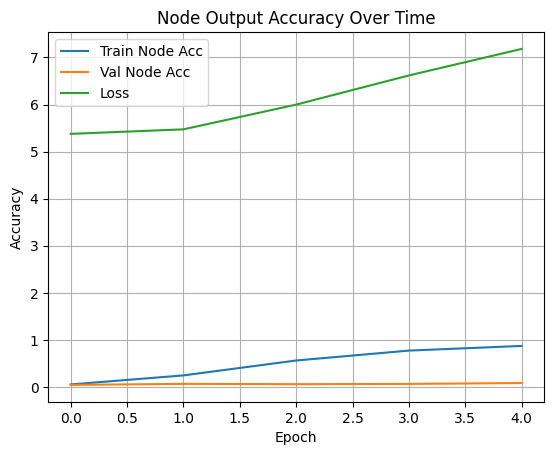

In [ ]:
plt.plot(history.history['node_output_accuracy'], label='Train Node Acc')
plt.plot(history.history['val_node_output_accuracy'], label='Val Node Acc')
plt.plot(history.history['val_node_output_loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Node Output Accuracy Over Time')
plt.legend()
plt.grid(True)
plt.show()

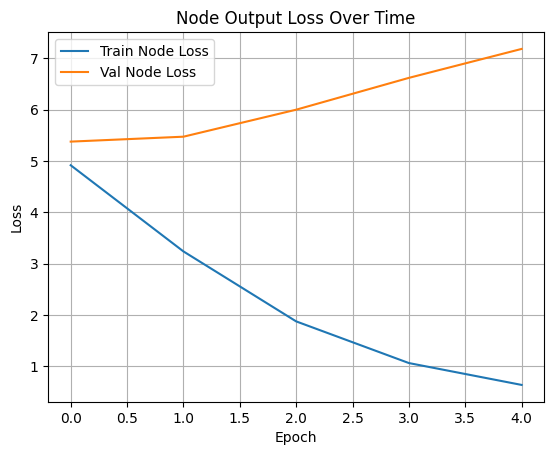

In [ ]:
plt.plot(history.history['node_output_loss'], label='Train Node Loss')
plt.plot(history.history['val_node_output_loss'], label='Val Node Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Node Output Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Step 1: Get predicted class indices based on the address that was provided
pred_node_probs, pred_speed_probs = model.predict(X)
pred_node_classes = np.argmax(pred_node_probs, axis=1)
pred_speed_classes = np.argmax(pred_speed_probs, axis=1)

537/537 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# Step 2: Decode back to words
pred_node_labels = node_encoder.inverse_transform(pred_node_classes)
true_node_labels = node_encoder.inverse_transform(y_node)
pred_speed_labels = speed_encoder.inverse_transform(pred_speed_classes)
true_speed_labels = speed_encoder.inverse_transform(y_speed)

In [ ]:
# Step 3: Create a results DataFrame
results_df = pd.DataFrame({
    "Address": df["Full_Address"],
    "Node_Actual": true_node_labels,
    "Node_Predicted": pred_node_labels,
    "Speed_Actual": true_speed_labels,
    "Speed_Predicted": pred_speed_labels
})

In [ ]:
results_df.head()

,Address,Node_Actual,Node_Predicted,Speed_Actual,Speed_Predicted
0,1924 Abby Ln York SC 297459613,LORA Allison Creek,LORA Allison Creek,MODEM SPEEDS 56K/128K,MODEM SPEEDS 56K/128K
1,1928 Abby Ln York SC 297452899,LORA Allison Creek,LORA Allison Creek,MODEM SPEEDS 56K/128K,MODEM SPEEDS 56K/128K
2,1935 Abby Ln York SC 297459613,LORA Allison Creek,LORA Allison Creek,MODEM SPEEDS 56K/128K,MODEM SPEEDS 56K/128K
3,1940 Abby Ln York SC 297459613,LORA Allison Creek,LORA Allison Creek,MODEM SPEEDS 56K/128K,MODEM SPEEDS 56K/128K
4,1960 Abby Ln York SC 29745,LORA Allison Creek,LORA Allison Creek,MODEM SPEEDS 56K/128K,MODEM SPEEDS 56K/128K


In [ ]:
# Check for accuracy...in a pilot with a vendor this would be something to list in the SOW as an milestone that represents a target to achieve

node_accuracy = np.mean(pred_node_labels == true_node_labels)
speed_accuracy = np.mean(pred_speed_labels == true_speed_labels)

print(f"\nNode Accuracy: {node_accuracy:.2%}")
print(f"Speed Accuracy: {speed_accuracy:.2%}")


Node Accuracy: 74.34%
Speed Accuracy: 97.28%


In [ ]:
# The work is done!....this fucntion is for the user input below to test the model

def predict_node_and_speed(address_string):
    # Step 1: Tokenize and pad the input
    seq = tokenizer.texts_to_sequences([address_string])
    padded = pad_sequences(seq, maxlen=X.shape[1], padding='post')

    # Step 2: Predict
    node_probs, speed_probs = model.predict(padded)
    node_class = np.argmax(node_probs, axis=1)[0]
    speed_class = np.argmax(speed_probs, axis=1)[0]

    # Step 3: Decode class back to label
    predicted_node = node_encoder.inverse_transform([node_class])[0]
    predicted_speed = speed_encoder.inverse_transform([speed_class])[0]

    return predicted_node, predicted_speed

In [ ]:
# The work is done!....this fucntion is for the user input below to test the model

def log_feedback(address, correct_node, correct_speed, file_path="feedback.csv"):

    print(pd.DataFrame([{
        "Full_Address": address,
        "Node": correct_node,
        "Speeds": correct_speed
    }]))

    try:
        existing = pd.read_csv(file_path)
        updated = pd.concat([existing, pd.DataFrame([{
        "Full_Address": address,
        "Node": correct_node,
        "Speeds": correct_speed
    }])], ignore_index=True).drop_duplicates()
    except FileNotFoundError:
        updated = pd.DataFrame([{
        "Full_Address": address,
        "Node": correct_node,
        "Speeds": correct_speed
    }])

    updated.to_csv(file_path, index=False)
    print("Feedback logged.")

In [ ]:
# the input works adn the model predicts correctly 75% of the time...retraining is not working yet.

user_input1 = input("Enter an address: ")
node, speed = predict_node_and_speed(user_input1)
print("Predicted Node:", node)
print("Predicted Speed:", speed)

user_input2 = input("Was the answer correct? (yes/no): ").strip().lower()

if user_input2 == "no":
    resubmitted_address = input("Re-enter the address: ")
    correct_node = input("Enter the correct node: ")
    correct_speed = input("Enter the correct speed: ")

    # Log the feedback
    log_feedback(resubmitted_address, correct_node, correct_speed)

    # Optionally re-predict from corrected input
    #node, speed = predict_node_and_speed(resubmitted_address)

    # Load original data
    original = pd.read_csv("AddressesByFacilitiesAndSpeedsReport_Cleaned.csv")

    print(original["Speeds"].value_counts())
    print(original["Node"].value_counts())

    # Load feedback corrections
    try:
      feedback = pd.read_csv("feedback.csv")
    except FileNotFoundError:
      feedback = pd.DataFrame(columns=["Full_Address", "Node", "Speeds"])

    # Combine datasets (no duplicates)
    combined = pd.concat([original, feedback], ignore_index=True).drop_duplicates(subset=["Full_Address"])

    print("Original.head",original.head())
    print("Original Speed",original["Speeds"].value_counts())

    # Build full address if not present
    if "Full_Address" not in combined.columns:
        combined["Full_Address"] = (
            combined["Street_Number"].astype(str).fillna("") + " " +
            combined["Street_Name"].fillna("") + " " +
            combined["City"].fillna("") + " " +
            combined["State"].fillna("") + " " +
            combined["Zip_Code"].astype(str).fillna("")
        ).str.strip()

    # Encode labels
    node_encoder = LabelEncoder()
    speed_encoder = LabelEncoder()

    combined["Node_Label"] = node_encoder.fit_transform(combined["Node"].astype(str))
    combined["Speed_Label"] = speed_encoder.fit_transform(combined["Speeds"].astype(str))

    print("Unique Speed classes:", combined["Speeds"].nunique())
    print("Unique Node classes:", combined["Node"].nunique())

    # Tokenize text
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(combined["Full_Address"].astype(str))
    address_seq = tokenizer.texts_to_sequences(combined["Full_Address"].astype(str))
    X = pad_sequences(address_seq, padding='post')

    # Extract targets
    y_node = combined["Node_Label"].values
    y_speed = combined["Speed_Label"].values

    # Build model
    vocab_size = len(tokenizer.word_index) + 1
    max_length = X.shape[1]
    num_nodes = len(node_encoder.classes_)
    num_speeds = len(speed_encoder.classes_)

    input_layer = Input(shape=(max_length,), name="address_input")
    x = Embedding(input_dim=vocab_size, output_dim=64)(input_layer)
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)

    node_output = Dense(num_nodes, activation='softmax', name="node_output")(x)
    speed_output = Dense(num_speeds, activation='softmax', name="speed_output")(x)

    model = Model(inputs=input_layer, outputs=[node_output, speed_output])

    model.compile(
        optimizer='adam',
        loss={
            "node_output": "sparse_categorical_crossentropy",
            "speed_output": "sparse_categorical_crossentropy"
        },
        metrics={
            "node_output": "accuracy",
            "speed_output": "accuracy"
        }
    )

    # Retrain model
    history = model.fit(
        X,
        {"node_output": y_node, "speed_output": y_speed},
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # Save the model and encoders if needed
    model.save("address_model.keras")

    print("Model retrained with feedback and saved as 'address_model.keras'")

    rt_node, rt_speed = predict_node_and_speed(resubmitted_address)

    print("Updated Prediction Based on Feedback:")
    print("Node:", rt_node)
    print("Speed:", rt_speed)

